In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

import gensim
import re
import string
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer,HashingVectorizer
from sklearn import model_selection
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm
from gensim.models import Word2Vec
from sklearn import decomposition, ensemble
import xgboost
import warnings
warnings.filterwarnings('ignore')

from keras.preprocessing.text import one_hot
from keras.regularizers import l1,l2,l1_l2
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense,Flatten,Dropout, GaussianNoise
from keras.layers import LSTM,GRU
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import TimeDistributed
from keras.layers import ConvLSTM2D,SpatialDropout1D
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.sequence import pad_sequences

import keras
from keras.optimizers import SGD
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from wordcloud import WordCloud, STOPWORDS

C:\Users\avafa\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")
Using TensorFlow backend.


In [3]:
file_path = r'D:\Tweet Sentiment Extraction'
train_path = r'D:\Tweet Sentiment Extraction\train.csv'
test_path = r'D:\Tweet Sentiment Extraction\test.csv'
sub_path = r'D:\Tweet Sentiment Extraction\sample_submission.csv'

In [4]:
train = pd.read_csv(train_path)
test = pd.read_csv(test_path)
sub = pd.read_csv(sub_path)

In [5]:
train.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [6]:
train.isnull().sum()

textID           0
text             1
selected_text    1
sentiment        0
dtype: int64

In [7]:
train[train.text.isnull()].index.tolist()

[314]

In [8]:
train.text.iloc[314]

nan

In [9]:
train.dropna(inplace = True)

In [10]:
test.head()

,textID,text,sentiment
0,f87dea47db,Last session of the day http://twitpic.com/67ezh,neutral
1,96d74cb729,Shanghai is also really exciting (precisely -...,positive
2,eee518ae67,"Recession hit Veronique Branquinho, she has to...",negative
3,01082688c6,happy bday!,positive
4,33987a8ee5,http://twitpic.com/4w75p - I like it!!,positive


In [11]:
test.isnull().sum()

textID       0
text         0
sentiment    0
dtype: int64

In [12]:
test.head()

,textID,text,sentiment
0,f87dea47db,Last session of the day http://twitpic.com/67ezh,neutral
1,96d74cb729,Shanghai is also really exciting (precisely -...,positive
2,eee518ae67,"Recession hit Veronique Branquinho, she has to...",negative
3,01082688c6,happy bday!,positive
4,33987a8ee5,http://twitpic.com/4w75p - I like it!!,positive


In [13]:
classes_num = train.sentiment.nunique()
print("There are {} number of classes in train dataset".format(classes_num) )
print("The percent of each class in train dataset:")
pd.DataFrame(train.sentiment.value_counts(normalize=True)).style.background_gradient(cmap='Blues')

There are 3 number of classes in train dataset
The percent of each class in train dataset:


,sentiment
neutral,0.404549
positive,0.312300
negative,0.283151


In [14]:
print(pd.DataFrame(train.sentiment.value_counts(normalize=True)).to_markdown())

|          |   sentiment |
|:---------|------------:|
| neutral  |    0.404549 |
| positive |    0.3123   |
| negative |    0.283151 |


In [15]:
classes_num = test.sentiment.nunique()
print("There are {} number of classes in test dataset".format(classes_num) )
print("The percent of each class in test dataset:")
pd.DataFrame(test.sentiment.value_counts(normalize=True)).style.background_gradient(cmap='Greens')


There are 3 number of classes in test dataset
The percent of each class in test dataset:


,sentiment
neutral,0.404641
positive,0.312111
negative,0.283248


#### Clean text function: to remove links, numbers, punctuations (except "****")
"****" has used in considerable number of docs mostly for taboo words

In [16]:
def pre_process(x):
    x = str(x).lower()
    x = re.sub(r'https?://\S+|www\.\S+', '', x) #to  remove links
    x = re.sub('\w*\d\w*', '', x) # to remove numbers
    if "****" in x:
        x = x.translate(str.maketrans('', '', string.punctuation)) ## removes any punctuations and brackets,#,@,*, _, etc,
        x = "****"+ " "+ x
        ## Considering that Taboo words have been substituted with "****"
    else:
        x = x.translate(str.maketrans('', '', string.punctuation)) ## removes any punctuations and brackets,#,@,*, _, etc,
    return(x)

### Function for preprocessing the docs: 
The docs are tokenized into words splitted by white space

stopwords removed

lemmatizer used to nomralize the texts


In [17]:
def tokenize(x):
    tokenizer = nltk.tokenize.WhitespaceTokenizer()
    stop_words = set(stopwords.words('english'))
    x = tokenizer.tokenize(x)
    x_stop_removed = [w for w in x if not w in stop_words]
    return x_stop_removed
    


In [18]:
train['text_clean'] = train.text.apply(pre_process)
train['selected_text_clean'] = train.selected_text.apply(pre_process)
train['text_words_clean'] = train.text_clean.apply(tokenize)
train['selected_text_words_clean'] = train.selected_text_clean.apply(tokenize)
#converting categorical classes to numerical variables
train['label'] = train.sentiment.astype('category').cat.codes


In [19]:
train.head()


,textID,text,selected_text,sentiment,text_clean,selected_text_clean,text_words_clean,selected_text_words_clean,label
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,id have responded if i were going,id have responded if i were going,"[id, responded, going]","[id, responded, going]",1
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,sooo sad i will miss you here in san diego,sooo sad,"[sooo, sad, miss, san, diego]","[sooo, sad]",0
2,088c60f138,my boss is bullying me...,bullying me,negative,my boss is bullying me,bullying me,"[boss, bullying]",[bullying],0
3,9642c003ef,what interview! leave me alone,leave me alone,negative,what interview leave me alone,leave me alone,"[interview, leave, alone]","[leave, alone]",0
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,**** sons of why couldnt they put them on th...,**** sons of,"[****, sons, couldnt, put, releases, already, ...","[****, sons]",0


In [20]:
test['text_clean'] = test.text.apply(pre_process)
test['text_words_clean'] = test.text_clean.apply(tokenize)
#converting categorical classes to numerical variables
test['label'] = test.sentiment.astype('category').cat.codes

In [21]:
test.head()

,textID,text,sentiment,text_clean,text_words_clean,label
0,f87dea47db,Last session of the day http://twitpic.com/67ezh,neutral,last session of the day,"[last, session, day]",1
1,96d74cb729,Shanghai is also really exciting (precisely -...,positive,shanghai is also really exciting precisely s...,"[shanghai, also, really, exciting, precisely, ...",2
2,eee518ae67,"Recession hit Veronique Branquinho, she has to...",negative,recession hit veronique branquinho she has to ...,"[recession, hit, veronique, branquinho, quit, ...",0
3,01082688c6,happy bday!,positive,happy bday,"[happy, bday]",2
4,33987a8ee5,http://twitpic.com/4w75p - I like it!!,positive,i like it,[like],2


In [22]:
emp_ind_train = train.text_words_clean[train.text_words_clean.apply(len) == 0].index
train.sentiment[emp_ind_train].value_counts()

neutral     63
negative     1
positive     1
Name: sentiment, dtype: int64

In [23]:
train.text[emp_ind_train]

8                                  Both of you
328                                     There!
641                                         no
1270                       Were have you been?
1385                what have you been up to ?
                         ...                  
26063                              So over it!
26482       and again http://twitpic.com/4wp8l
26513                         ... same to you!
26584    is over it.  http://plurk.com/p/rp5np
26939                                    I did
Name: text, Length: 65, dtype: object

In [24]:
emp_ind_test = test.text_words_clean[test.text_words_clean.apply(len) == 0].index
test.sentiment[emp_ind_test].value_counts()

neutral    11
Name: sentiment, dtype: int64

In [25]:
test.text[emp_ind_test]

196      ???    ?????? - http://bit.ly/nAcK2
363                                  me too.
912                                  me too!
920                              6 am.  you?
1228                                 Will do
1283                            How are you?
1327                                 will do
1523                             at `s with 
2028                                  Me too
2175             me too  what are you doing?
2965                            and we`re in
Name: text, dtype: object

#### As seen after pre-processing and toki=enizing the texts in both train and test Both are left with tweets without any word
But considering the labels of these tweets in both train and test it is seen almost all of them belong to Neutral class
so I replaced the empty tweets with "neutral" 


In [26]:
def tokenize_mod(x):
    tokenizer = nltk.tokenize.WhitespaceTokenizer()
    stop_words = set(stopwords.words('english'))
    x = tokenizer.tokenize(x)
    x_stop_removed = [w for w in x if not w in stop_words]
    if len(x_stop_removed) == 0:
        x_stop_removed = ['neutral']
    return x_stop_removed

In [27]:
train['text_clean_mod'] = train.text.apply(pre_process)
train['text_words_clean_mod'] = train.text_clean.apply(tokenize_mod)

test['text_clean_mod'] = test.text.apply(pre_process)
test['text_words_clean_mod'] = test.text_clean.apply(tokenize_mod)



#### Counter dict used to count the words for all classes:
The arbitrary number of common words (e.g. 1000) chosen for each class seperately.


In [28]:
vocab_text_pos = Counter()
vocab_text_neg = Counter()
vocab_text_neu = Counter()

for i in train[train.sentiment == 'positive'].loc[:,['text_words_clean_mod']].values.reshape(-1):
    vocab_text_pos.update(i)
# train[train.sentiment == 'positive'].loc[:,['text_words_clean']].values.reshape(-1)
top_pos_words = vocab_text_pos.most_common(10000)

for i in train[train.sentiment == 'negative'].loc[:,['text_words_clean_mod']].values.reshape(-1):
    vocab_text_neg.update(i)
# train[train.sentiment == 'positive'].loc[:,['text_words_clean']].values.reshape(-1)
top_neg_words = vocab_text_neg.most_common(10000)

for i in train[train.sentiment == 'neutral'].loc[:,['text_words_clean_mod']].values.reshape(-1):
    vocab_text_neu.update(i)
# train[train.sentiment == 'positive'].loc[:,['text_words_clean']].values.reshape(-1)
top_neu_words = vocab_text_neu.most_common(10000)
# print("+: {}\n-: {}\n@: {}".format(top_pos_words,top_neg_words,top_neu_words) )

### Following cell show the slected top 1000 words for each class:

In [29]:
top_pos = pd.DataFrame(top_pos_words)
top_pos.columns = ['pos_words','count+']

top_neg = pd.DataFrame(top_neg_words)
top_neg.columns = ['neg_words','count-']

top_neu = pd.DataFrame(top_neu_words)
top_neu.columns = ['neu_words','count@']

allwords = pd.concat((top_pos,top_neg,top_neu),axis = 1)

allwords.head(5).style.background_gradient(cmap = 'Greens', subset = ["count+"])\
                        .background_gradient(cmap = 'Reds', subset = ["count-"])\
                        .background_gradient(cmap = 'Blues', subset = ["count@"])

,pos_words,count+,neg_words,count-,neu_words,count@
0,day,1225,im,1226,im,1057
1,good,1046,****,529,get,623
2,love,876,like,476,go,576
3,happy,840,dont,469,day,505
4,im,742,cant,464,dont,491


In [30]:
words= allwords.loc[0:3155, ['pos_words','neg_words', 'neu_words' ]]
words = list(set(words.values.reshape(-1)))
vocabulary = {}
for index,word in enumerate(words):
    vocabulary[index] = word


#### Applying classic ML algorithms for classifying the docs into +/-/@ classes:
- Naive Bayes Classifier
- Linear Classifier
- Support Vector Machine
- Bagging Models
- Boosting Models

In [31]:
# train_x, valid_x, train_y, valid_y = model_selection.train_test_split(train['text'], train['label'], shuffle = True)
train_x, train_y,test_x, test_y = train['text'], train['label'], test['text'], test['label']


### Feture engineering :
- I.Counter vectors
- II. TF-IDF Vectors
- III. Word2Vec


#### I. Count Vectors as features:

In [32]:
# Counter vectorizer object initiated where custom pre_processor and tokenizer used 
# unigram_range  = (1,3) means unigram and  bigram and  trigram
# unigram_range  = (1,2) means unigram and  bigram which gives slightly better results for my case
count_vect = CountVectorizer(preprocessor=pre_process, tokenizer=tokenize_mod, max_features= 5000 ,ngram_range=(1, 2))
# It is fitted on all documents.
count_vect.fit(train['text'])

print(type(count_vect.vocabulary_))
print(type(count_vect.vocabulary_.items()))


bag_of_words = count_vect.transform(train['text'])
print(type(bag_of_words))
print(type(bag_of_words.toarray()))

# # Bag of words: is a mtrix where: each row is a doc and each column represents a word in vocabulary
# # Vocabulary: all words found in train data set
# # Bag of words[i][j] means occurence of word j in tweet i

sum_words = bag_of_words.sum(axis=0)
## sum_words is a vector gives the number of occurence of any word in all docs so the shape is (1, num of words in vocab)

words_freq = [(word, sum_words[0, idx]) for word, idx in count_vect.vocabulary_.items()]
###  words_freq : is a list of tuples where first item (x[0])in each tuple is the word and second item (x[1]) is the number of occurence

words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
top_words = words_freq[0:100]

# for word,freq in top_words:
#     print(word,freq)
    

<class 'dict'>
<class 'dict_items'>
<class 'scipy.sparse.csr.csr_matrix'>
<class 'numpy.ndarray'>


In [35]:
# Accordingly train, and validation datasets transformed
train_x_count =  count_vect.transform(train_x)
test_x_count =  count_vect.transform(test_x)

models = [naive_bayes.MultinomialNB(),naive_bayes.BernoulliNB(),linear_model.LogisticRegression(),svm.SVC(),ensemble.RandomForestClassifier()]
model_ = [naive_bayes.GaussianNB()]
models_gradient = [xgboost.XGBClassifier()]

accuracy = {}
for model in model_+models+models_gradient:
    if model in models:
        model.fit(train_x_count, train_y)
        accuracy[model] = (metrics.accuracy_score(model.predict(test_x_count), test_y)*100)
    elif model in model_:
        model.fit(train_x_count.toarray(), train_y)
        accuracy[model] = (metrics.accuracy_score(model.predict(test_x_count.toarray()), test_y)*100)
    else:
        model.fit(train_x_count.tocsc(), train_y)
        accuracy[model] = (metrics.accuracy_score(model.predict(test_x_count.tocsc()), test_y)*100)       

        
accuracy_count = pd.DataFrame(accuracy.values())
accuracy_count = accuracy_count.T
accuracy_count.columns = ['GaussianNB','Mul-NB', 'Bern-NB','LogisticReg','SVC','RanForest','XGBClass']
print(accuracy_count.to_markdown())

|    |   GaussianNB |   Mul-NB |   Bern-NB |   LogisticReg |     SVC |   RanForest |   XGBClass |
|---:|-------------:|---------:|----------:|--------------:|--------:|------------:|-----------:|
|  0 |      44.5671 |  66.2422 |   66.5252 |        68.704 | 69.8925 |     69.3831 |    63.0164 |


#### II. TF-IDF Vectors as features

In [36]:
tfidf_vect = TfidfVectorizer(preprocessor=pre_process,tokenizer=tokenize_mod,max_features=5000,ngram_range=(1, 2) )

tfidf_vect.fit(train['text'])
train_x_tfidf =  tfidf_vect.transform(train_x)
test_x_tfidf =  tfidf_vect.transform(test_x)



models = [naive_bayes.MultinomialNB(),naive_bayes.BernoulliNB(),linear_model.LogisticRegression(),svm.SVC(),ensemble.RandomForestClassifier()]
model_ = [naive_bayes.GaussianNB()]
models_gradient = [xgboost.XGBClassifier()]

accuracy = {}
for model in model_+models+models_gradient:
    if model in models:
        model.fit(train_x_tfidf, train_y)
        accuracy[model] = (metrics.accuracy_score(model.predict(test_x_tfidf), test_y)*100)
    elif model in model_:
        model.fit(train_x_tfidf.toarray(), train_y)
        accuracy[model] = (metrics.accuracy_score(model.predict(test_x_tfidf.toarray()), test_y)*100)
    else:
        model.fit(train_x_tfidf.tocsc(), train_y)
        accuracy[model] = (metrics.accuracy_score(model.predict(test_x_tfidf.tocsc()), test_y)*100)       

        
accuracy_tfidf = pd.DataFrame(accuracy.values())
accuracy_tfidf = accuracy_tfidf.T
accuracy_tfidf.columns = ['GaussianNB','Mul-NB', 'Bern-NB','LogisticReg','SVC','RanForest','XGBClass']
print(accuracy_tfidf.to_markdown())


|    |   GaussianNB |   Mul-NB |   Bern-NB |   LogisticReg |     SVC |   RanForest |   XGBClass |
|---:|-------------:|---------:|----------:|--------------:|--------:|------------:|-----------:|
|  0 |      45.7838 |  64.7708 |   66.5252 |       69.3831 | 70.3735 |     70.7131 |    63.2145 |


### Word2vec:

In [33]:
### Important: The sentences given to w2v modeling ------> should be list of lists of tokens
# window = 10: means 10 similar words for given word. size = 350 the vector size for each word. This vector size is the number of fetures for each word
w2v = gensim.models.Word2Vec(list(train.text_words_clean_mod), size=50, window=10, min_count=2, iter=100)

In [34]:
w2v.most_similar('bad')

[('fair', 0.59993577003479),
 ('badly', 0.5052626132965088),
 ('guilty', 0.45434677600860596),
 ('dying', 0.43488383293151855),
 ('good', 0.408413290977478),
 ('disappointed', 0.4083400368690491),
 ('ponytail', 0.3991432189941406),
 ('shelter', 0.39661705493927),
 ('horrible', 0.39267608523368835),
 ('neutral', 0.39050760865211487)]

In [36]:
stopwords = set(STOPWORDS)

def show_wordcloud(data, title = None,ax=None):
    wordcloud = WordCloud(
        background_color='white',
        max_words=100,
        max_font_size=30, 
        scale=3,
        random_state=1 
        )
    
    wordcloud=wordcloud.generate(str(data))
    ax.imshow(wordcloud,interpolation='nearest')
    ax.axis('off')
    #plt.show()

In [39]:
sent=train.sentiment.unique()
colors = ["blue","red", "green"]

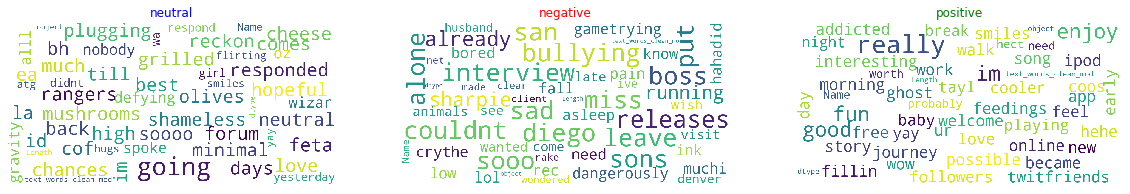

In [40]:
fig,ax=plt.subplots(1,3,figsize=(20,12))
for i in range(3):
    new=train[train['sentiment']==sent[i]]['text_words_clean_mod']
    show_wordcloud(new,ax=ax[i])
    ax[i].set_title(sent[i],color=colors[i])

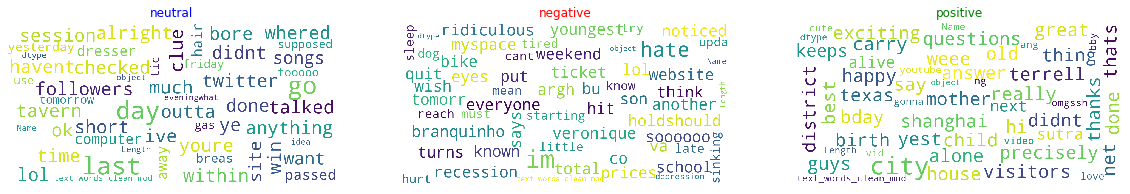

In [41]:
fig,ax=plt.subplots(1,3,figsize=(20,12))
for i in range(3):
    new=test[test['sentiment']==sent[i]]['text_words_clean_mod']
    show_wordcloud(new,ax=ax[i])
    ax[i].set_title(sent[i],color=colors[i])

In [42]:
def w2v_vector(x):
    """eliminates the words not available in w2v model's vocabulary and gives average word vector for any tweet given. """
    x = [word for word in x if word in w2v.wv.vocab]
    if len(x) == 0:
        x = [word for word in x]
        if len(x) == 0:
            x = ['neutral']
    return np.mean(w2v[x], axis=0)


In [43]:
train["word2vcs"] = train.text_words_clean_mod.apply(w2v_vector)
test["word2vcs"] = test.text_words_clean_mod.apply(w2v_vector)

In [51]:
train_X_w2v = list(train["word2vcs"])
test_X_w2v = list(test["word2vcs"])
models = [naive_bayes.GaussianNB(),naive_bayes.BernoulliNB(),linear_model.LogisticRegression(),svm.SVC(),ensemble.RandomForestClassifier()]
model_ = [xgboost.XGBClassifier()]
accuracy = {}
for model in models+model_:
    if model in models:
        model.fit(train_X_w2v, train_y)
        accuracy[model] = (metrics.accuracy_score(model.predict(test_X_w2v), test_y)*100)
    else:
        model.fit(np.array(train_X_w2v), train_y)
        accuracy[model] = (metrics.accuracy_score(model.predict(test_X_w2v), test_y)*100)        
        
        

accuracy_w2v = pd.DataFrame(accuracy.values())
accuracy_w2v = accuracy_w2v.T
accuracy_w2v.columns = ['GaussianNB', 'Bern-NB','LogisticReg','SVC','RanForest','XGBClass']
print(accuracy_w2v.to_markdown())    


|    |   GaussianNB |   Bern-NB |   LogisticReg |     SVC |   RanForest |   XGBClass |
|---:|-------------:|----------:|--------------:|--------:|------------:|-----------:|
|  0 |      54.2162 |   54.4143 |       59.7057 | 64.4029 |     60.4697 |    60.9791 |


### Neural Network (MLP):
- feature engineering with couter-vectorizer:

Train: 0.837, Test: 0.713


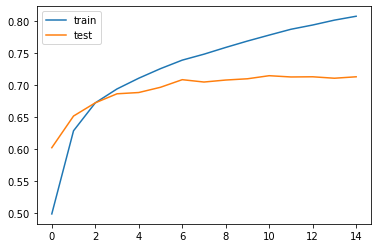

In [62]:
input_dim = train_x_count.toarray().shape[1]
num_classes = 3
train_y = train.label
train_y= np_utils.to_categorical(train_y)

test_y = test.label
test_y= np_utils.to_categorical(test_y)

### Create Model
model = Sequential()

# regularizers.l1_l2(l1=1e-5, l2=1e-4),
model.add(Dense(200, activation='relu',input_dim= input_dim, activity_regularizer=l1_l2(l1=1e-5, l2=1e-4)) )
model.add(Dropout(0.4))
model.add(Dense(num_classes , activation='softmax' ) )
# optimizer = keras.optimizers.Adam(lr=0.0001)
optimizer = SGD(lr=0.002, momentum=0.95)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
history = model.fit(train_x_count,train_y, validation_data=(test_x_count, test_y), epochs=15, verbose=0)
# evaluate the model
_, train_acc = model.evaluate(train_x_count,train_y, verbose=0)
_, test_acc = model.evaluate(test_x_count, test_y, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))
# plot training history
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show()

In [60]:
input_dim = train_x_count.toarray().shape[1]
num_classes = 3
train_y = train.label
train_y= np_utils.to_categorical(train_y)
# test_y = test.label
# test_y= np_utils.to_categorical(test_y)
### Create Model
model = Sequential()
#, activity_regularizer=l1(0.006)
model.add(Dense(200, activation='relu',input_dim= input_dim, activity_regularizer=l1_l2(l1=1e-5, l2=1e-4)))
model.add(Dropout(0.4))
model.add(Dense(num_classes , activation='softmax'))
optimizer = SGD(lr=0.002, momentum=0.95)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model.summary()
model.fit(train_x_count,train_y,epochs=15)
(metrics.accuracy_score(model.predict(test_x_count).argmax(axis=-1), test.label)*100)

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_43 (Dense)             (None, 200)               1000200   
_________________________________________________________________
dropout_21 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_44 (Dense)             (None, 3)                 603       
Total params: 1,000,803
Trainable params: 1,000,803
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
27480/27480 [==============================] - 8s 291us/step - loss: 1.0156 - accuracy: 0.4951
Epoch 2/15
27480/27480 [==============================] - 7s 265us/step - loss: 0.8680 - accuracy: 0.6227
Epoch 3/15
27480/27480 [==============================] - 7s 270us/step - loss: 0.7913 - accuracy: 0.6689
Epoch 4/15
27480/27480 [==============================]

70.7696661007357

### Neural Network (MLP): 
- feature engineering with word embedding layer:

In [45]:
num_classes = 3
### vocabulary is built form most frequent words in train data set. vocab_size = 5000
vocab_size = len(vocabulary)

#### Each tweet has different number of words so, the longest tweet found to make all tweet's lenghth the same.
sent_length = train['text_words_clean'].apply(len).max()

### Labes transformed as one hot encoded. as the output layer in MLP has 3  units
train_y = train.label
train_y= np_utils.to_categorical(train_y)
## The actual label on test data set. No need for OHE as we do not use it in training
test_y = test.label

#### So each tweet in train set is cleaned first by pre_process function 
tweets_train  = train['text_words_clean'].apply(lambda x: " ".join(x) )
  
### The words in each tweet then One hot encoded by vocab size
onehot_repr=[one_hot(tweet,vocab_size)for tweet in tweets_train]
### The one hot encoded words then transformed into vectors with fixed length and pre padding 
train_x_wv = pad_sequences(onehot_repr,padding='pre',maxlen=sent_length)



# The same process above for the test data set in order to prepare test_x
tweets_test  = test['text_words_clean'].apply(lambda x: " ".join(x))       
onehot_repr_test=[one_hot(tweet,vocab_size)for tweet in tweets_test]
test_x_wv = pad_sequences(onehot_repr_test,padding='pre',maxlen=sent_length)    



### As seen in PCA_components figure 15 components almost explains 100% of the variation in feature set  

pca explained variance ratio for train:  [3.11227611e-01 1.15742893e-01 8.10143503e-02 7.45859009e-02
 7.39642869e-02 6.86433808e-02 5.93406586e-02 5.07555517e-02
 4.23061439e-02 3.45264180e-02 2.75993741e-02 2.14285861e-02
 1.55208589e-02 1.04073030e-02 6.63095791e-03 3.31077564e-03
 1.69649917e-03 8.12225403e-04 2.90808941e-04 1.35335460e-04]
pca explained variance ratio for test:  [3.11819556e-01 1.17578634e-01 8.28658075e-02 7.62629569e-02
 7.36084736e-02 6.67455424e-02 5.92590965e-02 5.12566504e-02
 4.25361031e-02 3.36594929e-02 2.85920550e-02 2.08977600e-02
 1.42520135e-02 8.62196947e-03 6.63319056e-03 3.18221711e-03
 1.24155730e-03 7.86676242e-04 1.14121248e-04 8.57535940e-05]

----------------------------PCA-PLOT------------------------------------------------------


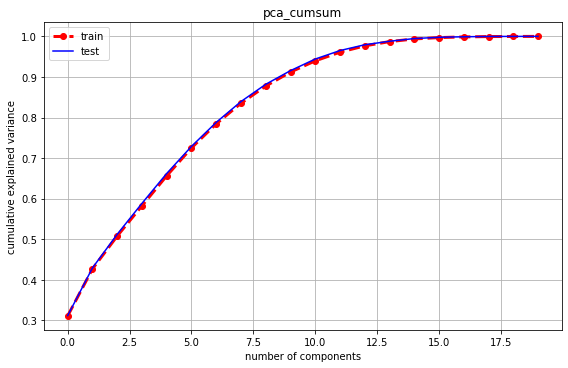

In [46]:
pca_train = PCA(n_components=20).fit(train_x_wv)     
pca_test =  PCA(n_components=20).fit(test_x_wv)
# np.array(onehot_repr_test).shape
print("pca explained variance ratio for train: ", pca_train.explained_variance_ratio_)
print("pca explained variance ratio for test: ", pca_test.explained_variance_ratio_)
print("\n----------------------------PCA-PLOT------------------------------------------------------")
plt.figure(figsize=(8,5))
plt.plot(np.cumsum(pca_train.explained_variance_ratio_),color = 'r', linestyle = '--', marker = 'o', linewidth = 3 , label = 'train' )
plt.plot(np.cumsum(pca_test.explained_variance_ratio_),color = 'b', label = 'test')
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.tight_layout()
plt.title('pca_cumsum')
plt.legend()
plt.grid()
plt.show()

In [47]:
# # create model
# with respect to PCA analysis, the dimension for feature set chosen as 14:
dimension = 14
model = Sequential()
model.add(Embedding(vocab_size, dimension , input_length=sent_length))
model.add(Flatten())
model.add(Dense(200, activation='relu', activity_regularizer=l1_l2(l1=1e-4, l2=1e-4)))
model.add(Dropout(0.4))
model.add(Dense(num_classes , activation='softmax'))
optimizer = SGD(lr=0.002, momentum=0.95)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

model.fit(train_x_wv,train_y,epochs=15)
(metrics.accuracy_score(model.predict(test_x_wv).argmax(axis=-1), test_y)*100)



Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Epoch 1/15
27480/27480 [==============================] - 2s 86us/step - loss: 1.0891 - accuracy: 0.4024
Epoch 2/15
27480/27480 [==============================] - 2s 75us/step - loss: 1.0856 - accuracy: 0.4045
Epoch 3/15
27480/27480 [==============================] - 2s 75us/step - loss: 1.0808 - accuracy: 0.4095
Epoch 4/15
27480/27480 [==============================] - 2s 76us/step - loss: 1.0613 - accuracy: 0.4518
Epoch 5/15
27480/27480 [==============================] - 2s 76us/step - loss: 1.0022 - accuracy: 0.5078
Epoch 6/15
27480/27480 [==============================] - 2s 76us/step - loss: 0.9323 - accuracy: 0.5536
Epoch 7/15
27480/27480 [==============================] - 2s 77us/step - loss: 0.8756 - accuracy: 0.6060
Epoch 8/15
27480/27480 [==============================] - 2s 84us/step - loss: 0.8256 - accuracy: 0.6469 0s - loss: 0.8
Epoch 9/15
27480/27480 [=

66.01584606677984

### Convelutional neural network (CNN):
https://machinelearningmastery.com/predict-sentiment-movie-reviews-using-deep-learning/

In [86]:
model = Sequential()
model.add(Embedding(vocab_size, dimension , input_length=sent_length))
model.add(SpatialDropout1D(0.3))
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(200, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(num_classes , activation='softmax'))
optimizer = SGD(lr=0.001, momentum=0.95)
# optimizer = optimizer = keras.optimizers.Adam(lr=0.001)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

model.fit(train_x_wv,train_y,epochs=30)
(metrics.accuracy_score(model.predict(test_x_wv).argmax(axis=-1), test_y)*100)


Epoch 1/18
27480/27480 [==============================] - 4s 152us/step - loss: 1.0867 - accuracy: 0.4017
Epoch 2/18
27480/27480 [==============================] - 4s 142us/step - loss: 1.0831 - accuracy: 0.4053
Epoch 3/18
27480/27480 [==============================] - 4s 146us/step - loss: 1.0774 - accuracy: 0.4141
Epoch 4/18
27480/27480 [==============================] - 4s 147us/step - loss: 1.0623 - accuracy: 0.4451
Epoch 5/18
27480/27480 [==============================] - 4s 150us/step - loss: 1.0198 - accuracy: 0.4898
Epoch 6/18
27480/27480 [==============================] - 4s 150us/step - loss: 0.9736 - accuracy: 0.5239
Epoch 7/18
27480/27480 [==============================] - 4s 150us/step - loss: 0.9382 - accuracy: 0.5409
Epoch 8/18
27480/27480 [==============================] - 4s 151us/step - loss: 0.9099 - accuracy: 0.5541
Epoch 9/18
27480/27480 [==============================] - 4s 151us/step - loss: 0.8804 - accuracy: 0.5835
Epoch 10/18
27480/27480 [=====================

66.10073571024336

### RNN- Long Short Term Model (LSTM)

In [51]:
model = Sequential()
model.add(Embedding(vocab_size, dimension , input_length=sent_length))
model.add(SpatialDropout1D(0.3))
model.add(LSTM(100, activation='relu', return_sequences=True))
model.add(LSTM(100, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(num_classes , activation='softmax'))
optimizer = SGD(lr=0.01, momentum=0.95)
# optimizer = optimizer = keras.optimizers.Adam(lr=0.001)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

model.fit(train_x_wv,train_y,epochs=10)
(metrics.accuracy_score(model.predict(test_x_wv).argmax(axis=-1), test_y)*100)

Epoch 1/10
27480/27480 [==============================] - 39s 1ms/step - loss: 1.0874 - accuracy: 0.4047
Epoch 2/10
27480/27480 [==============================] - 37s 1ms/step - loss: 1.0849 - accuracy: 0.4001
Epoch 3/10
27480/27480 [==============================] - 38s 1ms/step - loss: 1.0819 - accuracy: 0.4028
Epoch 4/10
27480/27480 [==============================] - 40s 1ms/step - loss: 1.0746 - accuracy: 0.4213 0s - loss: 1.0749 - 
Epoch 5/10
27480/27480 [==============================] - 38s 1ms/step - loss: 0.9698 - accuracy: 0.5190
Epoch 6/10
27480/27480 [==============================] - 36s 1ms/step - loss: 0.9024 - accuracy: 0.5582
Epoch 7/10
27480/27480 [==============================] - 37s 1ms/step - loss: 0.8540 - accuracy: 0.5870
Epoch 8/10
27480/27480 [==============================] - 36s 1ms/step - loss: 0.7941 - accuracy: 0.6464
Epoch 9/10
27480/27480 [==============================] - 43s 2ms/step - loss: 0.7577 - accuracy: 0.6705
Epoch 10/10
27480/27480 [=========

66.6383701188455

Train: 0.720, Test: 0.662


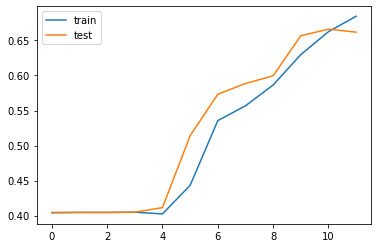

In [50]:
model = Sequential()
model.add(Embedding(vocab_size, dimension , input_length=sent_length))
model.add(SpatialDropout1D(0.3))
model.add(LSTM(100, activation='relu', return_sequences=True))
model.add(LSTM(100, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(num_classes , activation='softmax'))
optimizer = SGD(lr=0.01, momentum=0.95)
# optimizer = optimizer = keras.optimizers.Adam(lr=0.001)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

history = model.fit(train_x_wv,np_utils.to_categorical(train.label), validation_data=(test_x_wv, np_utils.to_categorical(test.label)), epochs=12, verbose=0)
# evaluate the model
_, train_acc = model.evaluate(train_x_wv,np_utils.to_categorical(train.label), verbose=0)
_, test_acc = model.evaluate(test_x_wv, np_utils.to_categorical(test.label), verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))
# plot training history
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show()


### RNN- Gated Recurrent Unit (GRU):

In [52]:
model = Sequential()
model.add(Embedding(vocab_size, dimension , input_length=sent_length))
model.add(SpatialDropout1D(0.3))
model.add(GRU(100, activation='relu', return_sequences=True))
model.add(GRU(100, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(num_classes , activation='softmax'))
optimizer = SGD(lr=0.01, momentum=0.95)
# optimizer = optimizer = keras.optimizers.Adam(lr=0.001)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

model.fit(train_x_wv,train_y,epochs=10)
(metrics.accuracy_score(model.predict(test_x_wv).argmax(axis=-1), test_y)*100)

Epoch 1/10
27480/27480 [==============================] - 46s 2ms/step - loss: 1.0884 - accuracy: 0.4039
Epoch 2/10
27480/27480 [==============================] - 41s 1ms/step - loss: 1.0853 - accuracy: 0.4031
Epoch 3/10
27480/27480 [==============================] - 42s 2ms/step - loss: 1.0691 - accuracy: 0.4281
Epoch 4/10
27480/27480 [==============================] - 39s 1ms/step - loss: 0.9498 - accuracy: 0.5298
Epoch 5/10
27480/27480 [==============================] - 39s 1ms/step - loss: 0.8494 - accuracy: 0.6048
Epoch 6/10
27480/27480 [==============================] - 40s 1ms/step - loss: 0.7945 - accuracy: 0.6506 0s - loss: 0.7
Epoch 7/10
27480/27480 [==============================] - 43s 2ms/step - loss: 0.7534 - accuracy: 0.6791
Epoch 8/10
27480/27480 [==============================] - 40s 1ms/step - loss: 0.7310 - accuracy: 0.6933
Epoch 9/10
27480/27480 [==============================] - 42s 2ms/step - loss: 0.7135 - accuracy: 0.7033
Epoch 10/10
27480/27480 [===============

65.61969439728354

### Digging more into Metrics:

In [53]:
from sklearn.metrics import confusion_matrix, f1_score,recall_score,precision_score,classification_report

In [54]:
pred = model.predict(test_x_wv).argmax(axis=-1) 
actual = test_y

In [56]:
target_names = ["negative","neutral","positive"]
print(classification_report(actual, pred, target_names=target_names))

              precision    recall  f1-score   support

    negative       0.79      0.47      0.59      1001
     neutral       0.62      0.66      0.64      1430
    positive       0.64      0.82      0.72      1103

    accuracy                           0.66      3534
   macro avg       0.68      0.65      0.65      3534
weighted avg       0.67      0.66      0.65      3534



### With respect to the classification report:
- The precision and recall for negative class is high and low respectively
- High precision means there are few tweets that classifier predicts as negative class by mistake ( while they are not negative) in other words there is a low chance for a tweet to be predicted as negative while it is not.
- Low recall shows that there are considerable number of tweets in dataset that are negative but the classifier predicts them as either positive or neutral class in other words there is a high chance that a tweet with negative sentiment is predicted as neutral or poostive.  
- with repect to the results we can conclude that training data set does not represents the test data set well. 